In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
os.chdir('/data/users4/xli/interpolation')
from data.utils import load_sz_score, load_asd_score
os.chdir('/data/users4/xli/interpolation/visualization')

In [2]:
# load datasets
data_path = '/data/users2/zfu/Matlab/GSU/Neuromark/Results'
# load demographic information
fbirn_sub_path = os.path.join(data_path, 'Subject_selection', 'FBIRN', 'sub_info_FBIRN.mat')
fbirn_sub_data, invalid_sub_ind = load_sz_score(fbirn_sub_path)
# concatenate patients and controls
n_sub = fbirn_sub_data.shape[0]
ind_pt = np.where(fbirn_sub_data[:, 0]==1)[0][:n_sub//2] # 125 SZ
ind_hc = np.where(fbirn_sub_data[:, 0]==2)[0][:(n_sub-ind_pt.shape[0])] # 141 CTR
sub_data = np.concatenate((fbirn_sub_data[ind_pt, :], fbirn_sub_data[ind_hc, :]), axis=0)
# split data into training and test sets
n_test = 41
n_train = n_sub - n_test
n_train_sq = np.sqrt(n_train).astype(np.int64)
ind_pt_test = ind_pt[:n_test//2]
ind_pt_train = ind_pt[n_test//2:]
ind_hc_test = ind_hc[:n_test-n_test//2]
ind_hc_train = ind_hc[n_test-n_test//2:]
sub_data_test = np.concatenate((fbirn_sub_data[ind_pt_test, :], fbirn_sub_data[ind_hc_test, :]), axis=0)
sub_data_train = np.concatenate((fbirn_sub_data[ind_pt_train, :], fbirn_sub_data[ind_hc_train, :]), axis=0)

res_path = '/data/users4/xli/interpolation/results/sfnc_sz/vae/hypopt/layer3/seed3'
grid_jv = np.load(os.path.join(res_path, 'grid_jv.npy'))
grid_jv_int = grid_jv * (n_train_sq-1)

In [3]:
n_score = sub_data_train.shape[1]
matrix_score = np.zeros((n_train_sq, n_train_sq, n_score))

for i in range(n_score):
    for j in range(n_train):
        x = n_train_sq-1 - np.round(grid_jv_int[j,1]).astype(int)
        y = np.round(grid_jv_int[j,0]).astype(int)
        matrix_score[x, y, i] = sub_data_train[j, i]

In [4]:
sm_list = ['Diagnosis', 'PANSS (positive)','PANSS (negative)','Speed of processing','Attention/Vigilance','Working memory','Verbal learning','Visual learning','Reasoning/Problem solving', 'Composite score', 'Age', 'Gender']

sz=matrix_score[:,:,0]==1
print(f"Diagnosis & ${np.sum(sz[:7,:])}$ & ${np.sum(sz[7:])}$ & ${np.sum(sz[:,:7])}$ & ${np.sum(sz[:,7:])}$ & ${np.sum(np.triu(sz))}$ & ${np.sum(np.tril(sz,k=-1))}$")

for i in range(3,10):
    upper=matrix_score[:7,:,i][sz[:7,:]]
    lower=matrix_score[7:,:,i][sz[7:,:]]
    left=matrix_score[:,:7,i][sz[:,:7]]
    right=matrix_score[:,7:,i][sz[:,7:]]
    upper_triangular=matrix_score[:,:,i][np.triu(sz)]
    lower_triangular=matrix_score[:,:,i][np.tril(sz,k=-1)]
    print(f"{sm_list[i]} & ${np.mean(upper):.2f}({np.std(upper):.1f})$ & ${np.mean(lower):.2f}({np.std(lower):.1f})$ & ${np.mean(left):.2f}({np.std(left):.1f})$ & ${np.mean(right):.2f}({np.std(right):.1f})$ & ${np.mean(upper_triangular):.2f}({np.std(upper_triangular):.1f})$ & ${np.mean(lower_triangular):.2f}({np.std(lower_triangular):.1f})$")

Diagnosis & $69$ & $36$ & $57$ & $48$ & $67$ & $38$
Speed of processing & $-1.35(1.0)$ & $-0.92(0.8)$ & $-1.13(0.9)$ & $-1.29(1.0)$ & $-1.34(1.0)$ & $-0.96(0.8)$
Attention/Vigilance & $-1.41(1.4)$ & $-1.05(1.2)$ & $-1.06(1.3)$ & $-1.55(1.4)$ & $-1.43(1.4)$ & $-1.05(1.2)$
Working memory & $-1.10(1.0)$ & $-0.79(0.9)$ & $-0.91(0.9)$ & $-1.10(1.0)$ & $-1.14(1.0)$ & $-0.74(0.9)$
Verbal learning & $-1.38(1.2)$ & $-1.11(0.9)$ & $-1.22(1.0)$ & $-1.37(1.2)$ & $-1.40(1.2)$ & $-1.10(1.0)$
Visual learning & $-1.09(1.1)$ & $-0.81(1.1)$ & $-0.92(1.0)$ & $-1.08(1.2)$ & $-1.11(1.1)$ & $-0.78(1.0)$
Reasoning/Problem solving & $-0.87(1.1)$ & $-0.40(0.9)$ & $-0.66(1.1)$ & $-0.76(1.0)$ & $-0.83(1.1)$ & $-0.49(0.9)$
Composite score & $-1.70(1.2)$ & $-1.21(1.0)$ & $-1.39(1.1)$ & $-1.71(1.3)$ & $-1.71(1.3)$ & $-1.22(0.9)$


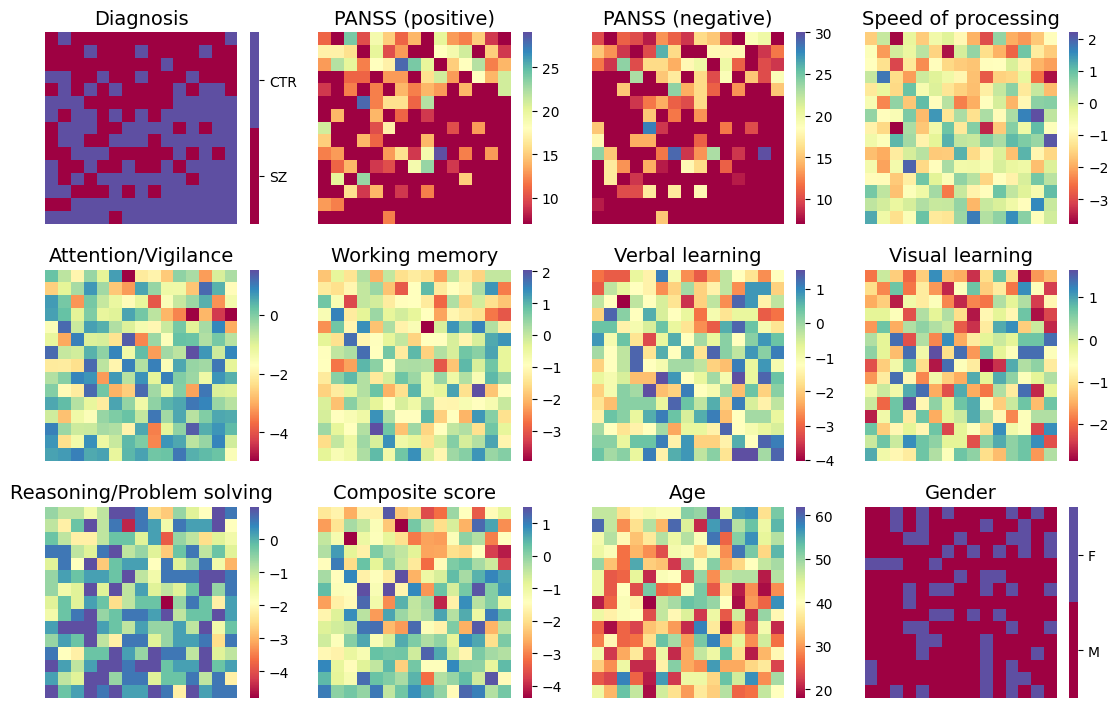

In [5]:
# visualize cognitive scores in 2D grid
cmap = mpl.cm.Spectral

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11, 7.2))

for i in range(12):
    row_idx = i//4
    col_idx = i%4
    if i == 0 or i == 11:
        cmap = plt.get_cmap('Spectral', 2)
    else:
        cmap = plt.get_cmap('Spectral')
    heatmap = sns.heatmap(matrix_score[:,:,i], cmap=cmap, ax=axes[row_idx, col_idx])
    if i == 0:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([1.25, 1.75])
        cbar.set_ticklabels(['SZ', 'CTR'])
    elif i == 11:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([1.25, 1.75])
        cbar.set_ticklabels(['M', 'F'])
    axes[row_idx, col_idx].set_axis_off()
    axes[row_idx, col_idx].set_title(sm_list[i], fontsize=14)

plt.tight_layout()
plt.savefig('fbirn_sm.pdf', bbox_inches='tight')

In [6]:
# load demographic information
abide1_sub_path = os.path.join(data_path, 'Subject_selection', 'ABIDE1', 'sub_info_ABIDE1_TRall.mat')
abide1_sub_data, abide1_site, invalid_sub_ind = load_asd_score(abide1_sub_path)

# concatenate patients and controls
n_sub = 266
ind_pt = np.where(((abide1_site=="NYU") | (abide1_site=="USM") | (abide1_site=="UCLA_1")) & (abide1_sub_data[:,0]==1))[0][:n_sub//2]
ind_hc = np.where(((abide1_site=="NYU") | (abide1_site=="USM") | (abide1_site=="UCLA_1")) & (abide1_sub_data[:,0]==2))[0][:n_sub-n_sub//2]

sub_data = np.concatenate((abide1_sub_data[ind_pt, :], abide1_sub_data[ind_hc, :]), axis=0)

age_pt = abide1_sub_data[ind_pt, -2]
age_hc = abide1_sub_data[ind_hc, -2]
sex_pt = abide1_sub_data[ind_pt, -1]
sex_hc = abide1_sub_data[ind_hc, -1]

n_test = 41
n_pt_test = n_test//2
n_hc_test = n_test - n_pt_test
ind_pt_test = []
ind_hc_test = []
site_patient = abide1_site[ind_pt]
site_control = abide1_site[ind_hc]
site_patient_list = list(np.unique(abide1_site[ind_pt]))
site_control_list = list(np.unique(abide1_site[ind_hc]))

for i, s in enumerate(site_patient_list):
    ind = np.where(site_patient == s)[0]
    # stratify test set by site
    n_start = ind[0]
    n_end = int(np.round(len(ind)/len(ind_pt)*n_test*0.5))
    ind_pt_site_test = ind_pt[n_start:n_start+n_end]
    ind_pt_test += list(ind_pt_site_test)

for i, s in enumerate(site_control_list):
    ind = np.where(site_control == s)[0]
    # stratify test set by site
    n_start = ind[0]
    n_end = int(np.round(len(ind)/len(ind_hc)*n_test*0.5))
    if s=="NYU":
        n_end += 1
    ind_hc_site_test = ind_hc[n_start:n_start+n_end]
    ind_hc_test += list(ind_hc_site_test)

# split data into training and test sets
n_train = n_sub - n_test
ind_pt_train = list(set(ind_pt) - set(ind_pt_test))
ind_hc_train = list(set(ind_hc) - set(ind_hc_test))

sub_data_test = np.concatenate((abide1_sub_data[ind_pt_test, :], abide1_sub_data[ind_hc_test, :]), axis=0)
sub_data_train = np.concatenate((abide1_sub_data[ind_pt_train, :], abide1_sub_data[ind_hc_train, :]), axis=0)

In [7]:
res_path = '/data/users4/xli/interpolation/results/sfnc_asd/vae/hypopt/layer2/seed6'
grid_jv = np.load(os.path.join(res_path, 'grid_jv.npy'))
grid_jv_int = grid_jv * (n_train_sq-1)

n_score = sub_data_train.shape[1]
matrix_score = np.zeros((n_train_sq, n_train_sq, n_score))

for i in range(n_score):
    for j in range(n_train):
        x = n_train_sq-1 - np.round(grid_jv_int[j,1]).astype(int)
        y = np.round(grid_jv_int[j,0]).astype(int)
        matrix_score[x, y, i] = sub_data_train[j, i]

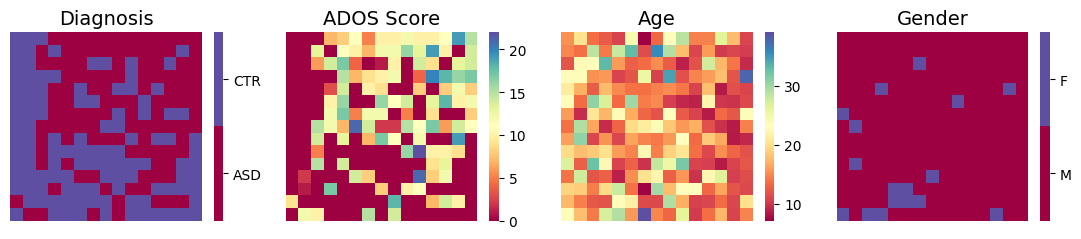

In [8]:
# visualize cognitive scores in 2D grid
sm_list = ['Diagnosis', 'ADOS Score', 'Age', 'Gender']
cmap = mpl.cm.Spectral

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(11, 2.5))

for i in range(4):
    if i == 0 or i == 3:
        cmap = plt.get_cmap('Spectral', 2)
    else:
        cmap = plt.get_cmap('Spectral')
    heatmap = sns.heatmap(matrix_score[:,:,i], cmap=cmap, ax=axes[i])
    if i == 0:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([1.25, 1.75])
        cbar.set_ticklabels(['ASD', 'CTR'])
    elif i == 3:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([1.25, 1.75])
        cbar.set_ticklabels(['M', 'F'])
    axes[i].set_axis_off()
    axes[i].set_title(sm_list[i], fontsize=14)

plt.tight_layout()
plt.savefig('abide_sm.pdf')